<br><h1> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="120" width="400" align="Center" /><br>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Redes convolucionales


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos las redes profundas convolucionales (CNN). Implementaremos nuestra propia red utilizando la biblioteca (API) Keras (https://keras.io/). 
    
                         Names                 User                Code
           - Romero Fonseca Angela Fernanda       af.romerof     201819276       
           - Juan Fernando Ortiz Serrano          jf.ortiz43     200623117
           - Elquin Huertas Ramírez               e.huertas      201920061

Probaremos nuestros modelos más complejos de *deep learning* para la detección automática de frailejones sobre imagenes aereas del páramo e intentaremos mejorar los resultados que obtuvimos con nuestras redes más sencillas. Recordemos que hasta ahora hemos logrado unos resultados preliminares con un *accuracy* de validación de 0.86, utilizando una red sencilla de 5 neuronas. 

Importemos algunos de los paquetes que vamos a utilizar:


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

from numpy.random import seed
seed(1)

Using TensorFlow backend.


In [2]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


## 1. Redes convolucionales

Las redes convolucionales (CNN: *Convolutional Neural Nets*) es un tipo de red neuronal (profunda) que suele usarse para el tratamiento de imagenes y la vision computacional, pero que también sirve para otras tareas como el procesamiento de datos secuenciales, lenguage natural, datos geo-referenciados o datos estructurados que guarden ciertas correlaciones entre sí (ver por ejemplo W. Kim (2014) Convolutional Neural Networks for Sentence Classification). 

Se les concoce por ser invariantes a translaciones, de tal manera que con su arquitectura producen exactamente la misma respuesta ante diferentes traslaciones (como por ejemplo rotaciones) que se le aplique a los datos de entrada. 

Un aspecto importante para entender las CNN de la mano con el tema que hemos visto hasta ahora en el curso, consiste en entender que los pesos y sesgos de una *capa convolucional* son **filtros** que extraen patrones particulares de los datos de entrada. Luego de la extracción de patrones, la red cuenta con capas densamente conectadas donde distintas neuronas pueden compartir el mismo filtro. 

Veamos:
https://medium.com/analytics-vidhya/deep-learning-methods-1700548a3093

Entonces, las CNN se pueden entender como versiones regularizadas de las redes multi-capa *densamente conectadas* (donde cada neurona en una capa está conectada con todas las demás neuronas de la siguiente capa). Este tipo de conexión *densa* facilita el *sobre-ajuste* a los datos de muestra con los que se construyen los mdoelos. Así, las CNN se enfocan en construir patrones más complejos pero más simples, encontrando *areas* de atención en las que enfocarse, haciendo uso de filtros y de **convoluciones** (formalmente hablando, una convolución corresponde con la operación matemática de la correlación cruzada). 

Veamos un ejemplo con un filtro de $3\times 3$ y una *stride* de 1:


$$ Imagen = \begin{bmatrix}
    1  & 1  & 1 & 0 & 0\\
    0 & 1 & 1 & 1 & 0 \\
    0  & 0 & 1  & 1 & 1 \\
    0 & 0 & 1 & 1 & 0 \\
    0  & 1 & 1  & 0 & 0
\end{bmatrix};\;\;\; Filtro = \begin{bmatrix}
    1  & 0  & 1\\
    0  & 1 & 0 \\
    1  & 0 & 1 
\end{bmatrix}; \;\;\; Patron =\begin{bmatrix}
    4  & 3  & 4\\
    2  & 4 & 3 \\
    2  & 3 & 4 
\end{bmatrix}$$

Para obtener el nuevo patrón convolucionado, resolvemos la operación $\otimes_1$ denotando una convolución con un *stride* de 1, o una *ventana móvil de 1 en 1*, tal que $Patron = Imagen \otimes_1 Filtro$.



Además de la operación convolucional, tras una capa convolucional le suele seguir un filtro de agregación conocido como **pooling**. Este filtro también toma ventanas móviles y resume los valores dentro de su rango de acuerdo con una operación de agregación específica.

Por ejmplo, un *Max-pooling* consiste en tomar el máximo dentro de cada ventana. Si tomamos un filtro de Max-pooling de tamaño $2\times 2$ y un *stride* de 2, y lo aplicamos sbre el patrón $P$, obtenemos:

$$ P = \begin{bmatrix}
    5  & 4  & 6 & 3\\
    3  & 9 & 4 & 5 \\
    8  & 1 & 7  & 9  \\
    0 & 2 & 8 & 0  
\end{bmatrix}\;\;\; $$

$$ MaxPool_{2\times 2}^{stride=2}(P) = \begin{bmatrix}
    9  & 6\\
    8  & 9
\end{bmatrix}$$


La gran ventaja de las CNN es que aprenden de manera automática (sin necesidad de conocimiento previo) los filtros que de otro modo habría que especificar explícita o manualmente. 

Especifiquemos a continuación la arquitectura de nuestra CNN, donde vamos a hacer uso de una técnica de **Drop-out** antes de la capa de salida. Esta técnica elimina aleatoriamente y de manera temporal (en cada iteración) un número de neuronas determinado (por una tasa de eliminación o *drop-out*), con el fin de que el modelo no recaiga demasidado en ciertas neuronas y generalize de la mejor manera la función a estimar :

In [25]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

### Optimizador de Adam

Vamos a implementar la red convolucional con la arquitectura especificada arriba haciendo uso del método de optimización estocástica de **Adam** (Kingma & Ba (2015)). El término *Adam* se debe a *Adaptive Moment Estimation*, y se puede entender como una revisión al método de RMSProp. Bajo Adam, se utilizan promedios móviles tanto de los gradientes como de sus segundos momentos.  De esta manera, se tiene que 

$$ u(\theta) = \rho_1 u(\theta_{viejo}) + (1-\rho_1) \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }  $$

$$ v(\theta) = \rho_2 v(\theta_{viejo}) + (1-\rho_2) \biggr( \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} } \biggl)^2  $$

donde

$$ \hat u = \frac{u(\theta)}{1-\rho_1^t} $$

$$ \hat v = \frac{v(\theta)}{1-\rho_2^t} $$

De tal manera que la actualización de los parámetros se lleva a cabo mediante:

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\hat u}{\sqrt{\hat v}+\varepsilon}$$ 

donde $\varepsilon$ es un escalar muy pequeño (infinitesimal) que previene la división por cero, $\rho_1, \rho_2$ son respectivamente  los factores de memoria sobre el primer y segundo momento de los gradientes. 

In [5]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)


Epoca= 20 , accu_v1=0.837837815284729 , accu_v2=0.8421052694320679
Epoca= 18 , accu_v1=0.45945945382118225 , accu_v2=0.6052631735801697
Epoca= 11 , accu_v1=0.5405405163764954 , accu_v2=0.6315789222717285
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8421 |   20  |
|  0.6   | 0.4595 | 0.6053 |   18  |
| 0.5771 | 0.5405 | 0.6316 |   11  |
+--------+--------+--------+-------+


### Pregunta 3.1

Qué puede observar sobre estos resultados?

- Con pocas épocas, el optimizador Adam logra obtener en la medida de desempeño niveles de predicción altos, respecto de los ejercicios de las redes neuronales profundas que requerían más épocas para su convergencia y optimización.
- Respecto del tiempo de ejecución para obtener un resultado comparable con lo obtenido en las redes neuronales profundas; en este caso fue mucho menor que en el del ejercicio de la semana anterior.


Visualicemos el aprendizaje del mejor modelo:

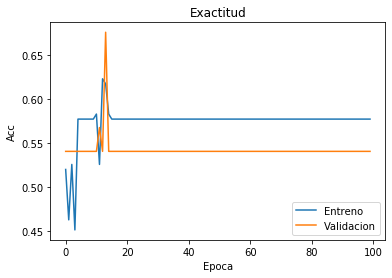

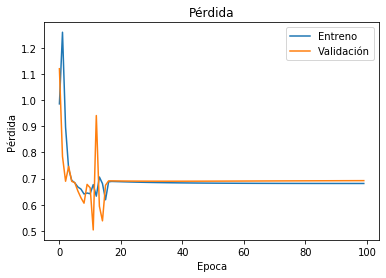

In [6]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [7]:
# red convolucional
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

Veamos el desempeño del mejor modelo sobre todo el conjunto de datos:

In [8]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  6,  99]], dtype=int64)

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 134 </td>
       <td> 11 </td>
    </tr>
    <tr>
       <td> 4 </td>
       <td> 101 </td>
    </tr>

</table>

### Ejercicio 1.1

Intente hacer que el optimizador Adam converja en todas las repeticiones. 


In [31]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.99, epsilon=1e-09)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.25, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.3, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 53 , accu_v1=0.8181818127632141 , accu_v2=0.9473684430122375
Epoca= 98 , accu_v1=0.8863636255264282 , accu_v2=0.8421052694320679
Epoca= 44 , accu_v1=0.8636363744735718 , accu_v2=0.9473684430122375
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9305 | 0.8182 | 0.9474 |   53  |
| 0.9251 | 0.8864 | 0.8421 |   98  |
| 0.9144 | 0.8636 | 0.9474 |   44  |
+--------+--------+--------+-------+


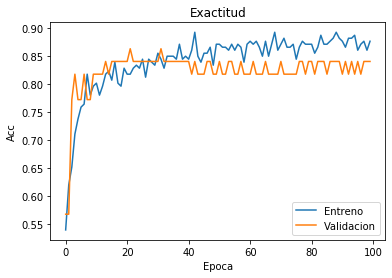

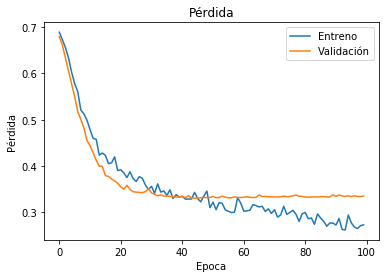

In [32]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

- Al disminuir la tasa de aprendizaje y los betas del optimizador y también definiendo un epsilon (1e-9) menor que el default (1e-7), las repeticiones obtienen mejores resultados en la medida de desempeño, siendo ésta similar en cada una de ellas y mucho mejores que en el ejercicio anterior.  
- Se realizaron varias pruevas disminuyendo la proporción de la muestra de prueba, observamos que el modelo se sobre ajusta.
- Se definió el porcentaje de muestra de prueba entre 0.25 y 0.3, obteniendo un mayor valor en la mejor medida de desempeño; es posible que aún así se esté presentando una situación de sobre ajuste; por tanto, más adelante se analizará si al utilizar la técnica de "dropout" este resultado se modifica por efecto de controlar el fenómeno de sobre ajuste. 
- La convergencia de la exactitud y la pérdida se ven adecuadas a partir de la época 20 aproximadamente, siendo en la función de pérdida mucho más estable que en la de exactitud.

### Ejercicio 1.2

Compare los resultados al utilizar otros algoritmos de aprendizaje como RMSprop o el mismo SGD


#### Prueba con RMSProp 

In [12]:
# Guardamos la arquitectura de red
config_He = model.get_config()
model = Sequential()   
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
model.add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(15, kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01), activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_He = model.get_config()

Inicio Init=He:2020-09-19 12:23:51.751688
Epoca= 196 , accu_v1=1.0 , accu_v2=0.9736841917037964
Fin Init= He:2020-09-19 12:29:54.208014


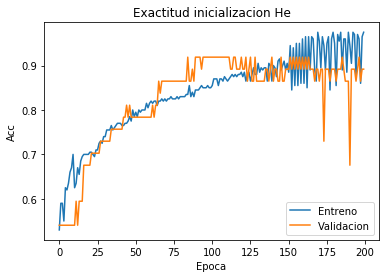

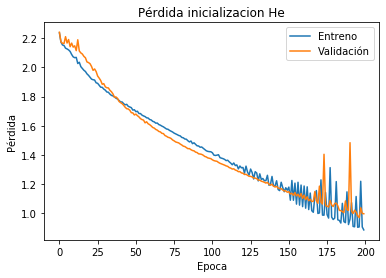

+--------+--------+--------+-------+------+
| Exac_E | Exac_V | Exac_P | Epoca | Init |
+--------+--------+--------+-------+------+
|  1.0   |  1.0   | 0.9737 |  196  |  He  |
+--------+--------+--------+-------+------+


In [13]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# Inicializacion aleatoria con He

model = Sequential.from_config(config_He)
init = "He"
tiempo0 = datetime.datetime.now()
print('Inicio Init=' +str(init)+':' +str(tiempo0))

# Partimos los datos en entrenamiento y doble validación
CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.2, random_state = 8)
# CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)

# Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

# Ajustamos el modelo
history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  

# Encontramos el mejor modelo en validación
min_err=np.min(history.history['val_loss'])
best_epoc=np.where(history.history['val_loss'] == min_err)[0] 

# Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

# Calculamos las metricas
train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)

# Guardamos las métricas de desempeño
accu_e = train_metrics[1]
loss_e = train_metrics[0]
accu_v = valid_metrics[1]
loss_v = valid_metrics[0]
accu_p = test_metrics[1]
loss_p = test_metrics[0]

pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
model.save(pathr) 
err_p = loss_p

x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])

# Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
tiempo1 = datetime.datetime.now()
print('Fin Init= ' +str(init)+':' +str(tiempo1))

# Graficamos el desempeño del modelo
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud inicializacion ' +str(init))  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida inicializacion ' +str(init))  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

print(x)

#### Prueba con SGD

In [14]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud 
    # para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=1_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 672 y accu_v=0.837837815284729
Epoca= 522 y accu_v=0.837837815284729
Epoca= 332 y accu_v=0.7837837934494019
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8158 |  672  |
| 0.9943 | 0.8378 | 0.7895 |  522  |
| 0.9771 | 0.7838 | 0.8421 |  332  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.99; Validacion1: 0.82; Validacion2: 0.816


- Comparando los resultados obtenidos para la medida de desempeño (acuraccy) frente al optimizador Adam contra la metodología de propagación de la tasa de aprendizaje RMSProp, ésta última arrojó mejores resultados que el primero, a pesar de las modificaciones en sus parámetros (Tasa de aprendizaje, betas y epsilon).
- Al realizar una comparación con la metodología del descenso en el gradiente estocástico (SGD), Adam obtuvo mejores resultados en la medida de desempeño utilizada.

### Ejercicio 1.3

Compare los resultados con distintas tasas de *drop-out*.  

 - Tasa Dropout=0.05

In [23]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.05, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [24]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.99, epsilon=1e-09)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 81 , accu_v1=0.837837815284729 , accu_v2=0.9210526347160339
Epoca= 97 , accu_v1=0.8918918967247009 , accu_v2=0.8157894611358643
Epoca= 96 , accu_v1=0.7837837934494019 , accu_v2=0.8421052694320679
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9257 | 0.8378 | 0.9211 |   81  |
| 0.9257 | 0.8919 | 0.8158 |   97  |
|  0.92  | 0.7838 | 0.8421 |   96  |
+--------+--------+--------+-------+


 - Tasa Dropout=0.1

In [15]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.1, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [16]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.99, epsilon=1e-09)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 81 , accu_v1=0.837837815284729 , accu_v2=0.9210526347160339
Epoca= 98 , accu_v1=0.837837815284729 , accu_v2=0.7894737124443054
Epoca= 61 , accu_v1=0.7837837934494019 , accu_v2=0.8684210777282715
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9257 | 0.8378 | 0.9211 |   81  |
| 0.9371 | 0.8378 | 0.7895 |   98  |
| 0.9086 | 0.7838 | 0.8684 |   61  |
+--------+--------+--------+-------+


 - Tasa Dropout=0.15

In [33]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.15, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [34]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.99, epsilon=1e-09)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.25, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.4, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 62 , accu_v1=0.837837815284729 , accu_v2=0.9230769276618958
Epoca= 93 , accu_v1=0.837837815284729 , accu_v2=0.8846153616905212
Epoca= 45 , accu_v1=0.8108108043670654 , accu_v2=0.9615384340286255
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9305 | 0.8378 | 0.9231 |   62  |
| 0.9305 | 0.8378 | 0.8846 |   93  |
| 0.9144 | 0.8108 | 0.9615 |   45  |
+--------+--------+--------+-------+


 - Tasa Dropout=0.3


In [17]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.3, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [18]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.99, epsilon=1e-09)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 85 , accu_v1=0.8648648858070374 , accu_v2=0.9210526347160339
Epoca= 98 , accu_v1=0.837837815284729 , accu_v2=0.8157894611358643
Epoca= 94 , accu_v1=0.7837837934494019 , accu_v2=0.8684210777282715
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9371 | 0.8649 | 0.9211 |   85  |
| 0.9429 | 0.8378 | 0.8158 |   98  |
|  0.92  | 0.7838 | 0.8684 |   94  |
+--------+--------+--------+-------+


 - Tasa Dropout=0.4

In [19]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.4, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [20]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.99, epsilon=1e-09)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 85 , accu_v1=0.8648648858070374 , accu_v2=0.8947368264198303
Epoca= 98 , accu_v1=0.8918918967247009 , accu_v2=0.8157894611358643
Epoca= 97 , accu_v1=0.7837837934494019 , accu_v2=0.8684210777282715
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9314 | 0.8649 | 0.8947 |   85  |
| 0.9371 | 0.8919 | 0.8158 |   98  |
| 0.9314 | 0.7838 | 0.8684 |   97  |
+--------+--------+--------+-------+


 - Tasa Dropout=0.5

In [21]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.5, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [22]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.99, epsilon=1e-09)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 85 , accu_v1=0.837837815284729 , accu_v2=0.8947368264198303
Epoca= 99 , accu_v1=0.8918918967247009 , accu_v2=0.8157894611358643
Epoca= 96 , accu_v1=0.8918918967247009 , accu_v2=0.8947368264198303
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9314 | 0.8378 | 0.8947 |   85  |
| 0.9371 | 0.8919 | 0.8158 |   99  |
| 0.9314 | 0.8919 | 0.8947 |   96  |
+--------+--------+--------+-------+


- Luego de probar diferentes tasas de Dropout con las cuales podemos eliminar una proporción de neuronas en una de las capas, en este caso la penúltima, de tal manera que el modelo evite recaer en una neurona determinida provocando posibles sobreajustes, se observó que para tasas hasta de 0.3, la mejor medida de desempeño obtenida se mantiene; no obstante, para tasas de Dropout mayores, dicha medida disminuye indicando que se estaría eliminando un alto porcentaje de neuronas que evitan una adecuada clasificación en el modelo. 

### Bono

Visualice los distintos filtros convolucionales para entender qué tipo de patrones están aprendiendo que son relevantes para la detección de frailejones.

*A continuación se indica cómo visulizar una capa convolucional. Examine las distintas capas convolucionales y analice lo que puede visualizar.*

In [40]:
import pandas as pd

In [43]:
#Formato para mostrar los datos
pd.options.display.float_format = '{:,.6f}'.format

In [59]:
# red convolucional con Dropout=0.15 fue el escogido.
model_3 = load_model('modelo_CNN_initseed=1_part_seed=1.h5')

model_3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 3136)            

In [60]:
from matplotlib import pyplot

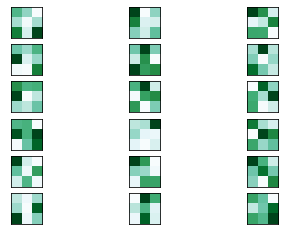

In [61]:
# cargamos los pesos de la primera capa escondida
filters, biases = model_3.layers[0].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 6, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='BuGn')
        ix += 1
# graficamos la figura
pyplot.show()

- Inicialmente los filtros permiten el aprendizaje de imagen en los extremos , una vez reconocidos los patrones allí, los filtros se pasan a aprender los puntos intermedios del borde de la imagen. 

- Posteriormente, aprende de los puntos centrales de la imagen y al final distingue patrones tanto de los extremos como de los intermedios de manera conjunta.

## 2. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


In [ ]:
from keras.preprocessing.image import image

img = image.load_img("images/IMG_3451.JPG")
img

### Red Convolucional

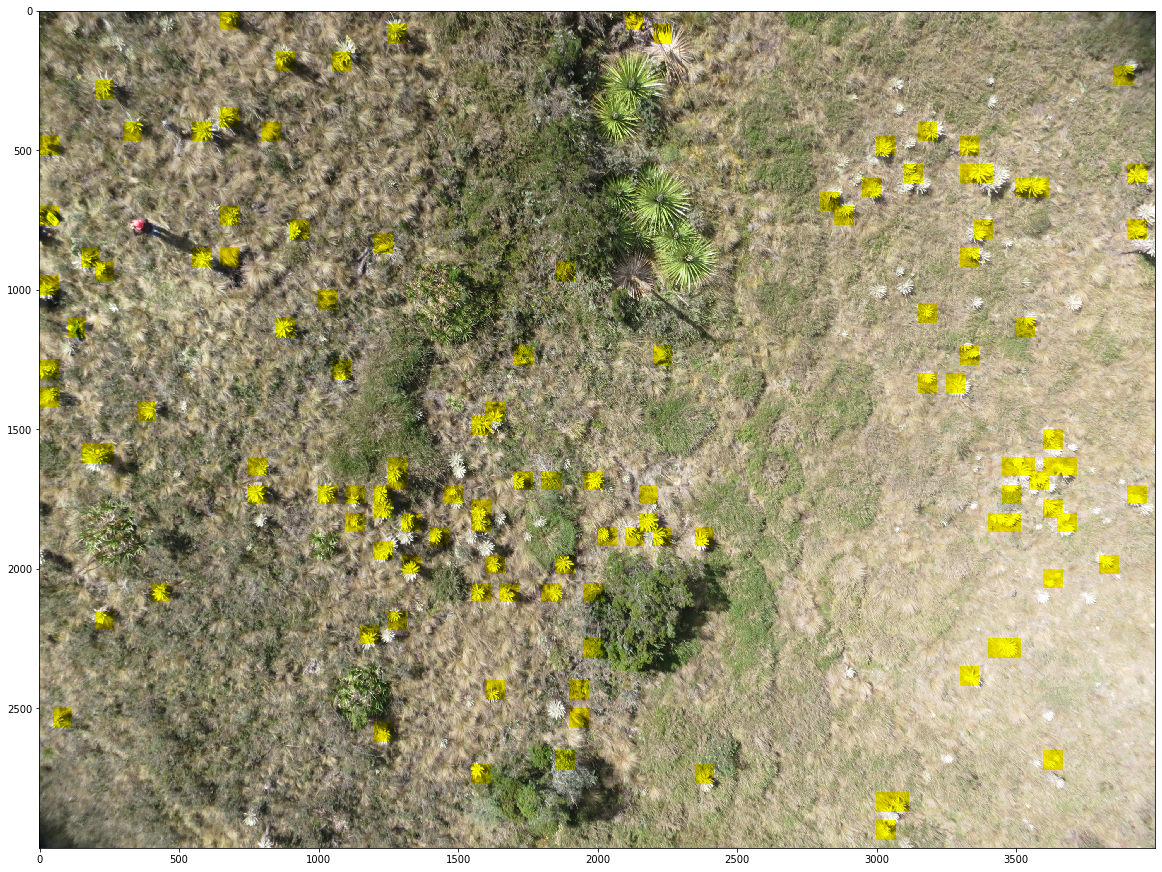

In [62]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_3.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)


Lectura avanzada sobre métodos de optimización en redes profundas: https://openreview.net/pdf?id=ryQu7f-RZ
http://www.cs.utoronto.ca/~ilya/pubs/2013/1051_2.pdf
        

- Bajo el modelo que involucra Redes convolucionales y la técnica de Dropout, el modelo se equivoca mucho menos, identifando frailejones en zonas donde antes no los identificaba. No obstante, se equivoca en zonas de pasto o arbustos tupidos en algunos casos.  